<a href="https://colab.research.google.com/github/sania-bairagdar/WEEK-3-SOLAR-ENERGY-PREDICTION/blob/main/WEEK3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving SolarPrediction_cleaned.csv to SolarPrediction_cleaned.csv


In [2]:
# === 0. Install any missing libraries ===
!pip install -q xgboost joblib

# === 1. Imports ===
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import joblib


In [3]:
# === 2. Load dataset ===
# If you uploaded the CSV to Colab session:
csv_path = '/content/SolarPrediction_cleaned.csv'   # change to '/content/drive/MyDrive/...' if using Drive
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
df.head(8)


Shape: (32686, 11)


,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirectionDegrees,Speed,TimeSunRise,TimeSunSet
0,1970-01-01 00:00:01.475229326,9/29/2016 12:00:00 AM,2025-11-03 23:55:26,1.21,48,30.46,59,177.39,5.62,2025-11-03 06:13:00,2025-11-03 18:13:00
1,1970-01-01 00:00:01.475229023,9/29/2016 12:00:00 AM,2025-11-03 23:50:23,1.21,48,30.46,58,176.78,3.37,2025-11-03 06:13:00,2025-11-03 18:13:00
2,1970-01-01 00:00:01.475228726,9/29/2016 12:00:00 AM,2025-11-03 23:45:26,1.23,48,30.46,57,158.75,3.37,2025-11-03 06:13:00,2025-11-03 18:13:00
3,1970-01-01 00:00:01.475228421,9/29/2016 12:00:00 AM,2025-11-03 23:40:21,1.21,48,30.46,60,137.71,3.37,2025-11-03 06:13:00,2025-11-03 18:13:00
4,1970-01-01 00:00:01.475228124,9/29/2016 12:00:00 AM,2025-11-03 23:35:24,1.17,48,30.46,62,104.95,5.62,2025-11-03 06:13:00,2025-11-03 18:13:00
5,1970-01-01 00:00:01.475227824,9/29/2016 12:00:00 AM,2025-11-03 23:30:24,1.21,48,30.46,64,120.20,5.62,2025-11-03 06:13:00,2025-11-03 18:13:00
6,1970-01-01 00:00:01.475227519,9/29/2016 12:00:00 AM,2025-11-03 23:25:19,1.20,49,30.46,72,112.45,6.75,2025-11-03 06:13:00,2025-11-03 18:13:00
7,1970-01-01 00:00:01.475227222,9/29/2016 12:00:00 AM,2025-11-03 23:20:22,1.24,49,30.46,71,122.97,5.62,2025-11-03 06:13:00,2025-11-03 18:13:00


In [4]:
# === 3. Quick EDA (exact checks you must run) ===
print("Column names:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nBasic stats for numeric columns:\n", df.describe().T)


Column names: ['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirectionDegrees', 'Speed', 'TimeSunRise', 'TimeSunSet']

Data types:
 UNIXTime                 object
Data                     object
Time                     object
Radiation               float64
Temperature               int64
Pressure                float64
Humidity                  int64
WindDirectionDegrees    float64
Speed                   float64
TimeSunRise              object
TimeSunSet               object
dtype: object

Missing values per column:
 UNIXTime                0
Data                    0
Time                    0
Radiation               0
Temperature             0
Pressure                0
Humidity                0
WindDirectionDegrees    0
Speed                   0
TimeSunRise             0
TimeSunSet              0
dtype: int64

Basic stats for numeric columns:
                         count        mean         std    min      25%     50%  \
Radiation          

In [5]:
# === 4. Set target column ===
target = 'Radiation'   # <<--- CHANGE here if your real target differs
if target not in df.columns:
    raise Exception(f"Target column {target} not found. Columns: {df.columns.tolist()}")


In [6]:
# === 5. Feature engineering: convert time/date columns to numeric features ===
# Identify columns that look like dates/time
print("Sample unique values (for time columns):")
print("UNIXTime sample:", df['UNIXTime'].head(3).tolist())
print("Data sample:", df['Data'].head(3).tolist())
print("Time sample:", df['Time'].head(3).tolist())
print("TimeSunRise sample:", df['TimeSunRise'].head(3).tolist())
print("TimeSunSet sample:", df['TimeSunSet'].head(3).tolist())

# Convert combined date/time if possible
# Try to build a single datetime column from 'Data' and 'Time' columns if present
try:
    # many datasets use "Data" as date; adjust if different
    df['datetime'] = pd.to_datetime(df['Data'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')
except Exception as e:
    print("Datetime conversion error (you may need to adjust columns):", e)

# If datetime successfully parsed, extract useful cyclical/time features:
if df['datetime'].notnull().sum() > 0:
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['dayofyear'] = df['datetime'].dt.dayofyear
    # Add simple cyclical encoding for hour (useful for solar patterns)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    # optionally drop raw datetime strings to avoid duplication
else:
    print("Datetime parsing failed or not present; proceed with existing features.")


Sample unique values (for time columns):
UNIXTime sample: ['1970-01-01 00:00:01.475229326', '1970-01-01 00:00:01.475229023', '1970-01-01 00:00:01.475228726']
Data sample: ['9/29/2016 12:00:00 AM', '9/29/2016 12:00:00 AM', '9/29/2016 12:00:00 AM']
Time sample: ['2025-11-03 23:55:26', '2025-11-03 23:50:23', '2025-11-03 23:45:26']
TimeSunRise sample: ['2025-11-03 06:13:00', '2025-11-03 06:13:00', '2025-11-03 06:13:00']
TimeSunSet sample: ['2025-11-03 18:13:00', '2025-11-03 18:13:00', '2025-11-03 18:13:00']


/tmp/ipython-input-2563640963.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['Data'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')


Datetime parsing failed or not present; proceed with existing features.


In [7]:
# === 6. Prepare X and y ===
# Drop columns that are non-informative for model or that include the target
drop_cols = ['UNIXTime','Data','Time','TimeSunRise','TimeSunSet','datetime']  # datetime drop optional
drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols + [target])
y = df[target].values

# Convert categorical to dummies (if any object columns remain)
X = pd.get_dummies(X, drop_first=True)

# Fill missing values in features (numeric mean imputation)
X = X.fillna(X.mean())

print("Feature matrix shape:", X.shape)
print("First few feature names:", X.columns.tolist()[:20])


Feature matrix shape: (32686, 5)
First few feature names: ['Temperature', 'Pressure', 'Humidity', 'WindDirectionDegrees', 'Speed']


In [8]:
# === 7B. Time-based split (preferred if 'datetime' exists) ===
if 'datetime' in df.columns and df['datetime'].notnull().sum() > 0:
    df2 = pd.concat([X, pd.Series(y, name=target)], axis=1)
    df2['datetime'] = df['datetime'].values  # align index
    df2 = df2.sort_values('datetime').reset_index(drop=True)
    n = len(df2)
    train_end = int(0.7 * n)
    val_end = int(0.85 * n)
    train_df = df2.iloc[:train_end]
    val_df = df2.iloc[train_end:val_end]
    test_df = df2.iloc[val_end:]
    X_train, y_train = train_df.drop(columns=[target,'datetime']), train_df[target].values
    X_val, y_val = val_df.drop(columns=[target,'datetime']), val_df[target].values
    X_test, y_test = test_df.drop(columns=[target,'datetime']), test_df[target].values
    print("Time split sizes (train/val/test):", len(X_train), len(X_val), len(X_test))
else:
    print("Datetime not available for time-based split; use random split above.")


Datetime not available for time-based split; use random split above.


In [9]:
# --- Create a valid datetime column from 'Data' and 'Time' ---
import pandas as pd

# Combine date and time columns into one
df['datetime'] = pd.to_datetime(df['Data'] + ' ' + df['Time'], errors='coerce')

# Check if conversion worked
print(df[['Data', 'Time', 'datetime']].head(10))
print("Number of valid datetime values:", df['datetime'].notnull().sum())


/tmp/ipython-input-1836506532.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['Data'] + ' ' + df['Time'], errors='coerce')


                    Data                 Time datetime
0  9/29/2016 12:00:00 AM  2025-11-03 23:55:26      NaT
1  9/29/2016 12:00:00 AM  2025-11-03 23:50:23      NaT
2  9/29/2016 12:00:00 AM  2025-11-03 23:45:26      NaT
3  9/29/2016 12:00:00 AM  2025-11-03 23:40:21      NaT
4  9/29/2016 12:00:00 AM  2025-11-03 23:35:24      NaT
5  9/29/2016 12:00:00 AM  2025-11-03 23:30:24      NaT
6  9/29/2016 12:00:00 AM  2025-11-03 23:25:19      NaT
7  9/29/2016 12:00:00 AM  2025-11-03 23:20:22      NaT
8  9/29/2016 12:00:00 AM  2025-11-03 23:15:22      NaT
9  9/29/2016 12:00:00 AM  2025-11-03 23:10:22      NaT
Number of valid datetime values: 0


In [10]:
# --- 🕒 Feature Engineering: Add Time-based Features before splitting ---
import numpy as np

# Ensure datetime column exists
if 'datetime' not in df.columns:
    df['datetime'] = pd.to_datetime(df['Time'], errors='coerce')

# Extract time-related features
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['dayofyear'] = df['datetime'].dt.dayofyear

# Add cyclical encodings for repeating patterns (helps model understand day/month cycles)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Recreate features (X) and target (y)
target = 'Radiation'
drop_cols = ['UNIXTime','Data','Time','TimeSunRise','TimeSunSet','datetime']

X = df.drop(columns=drop_cols + [target])
y = df[target]

# Handle missing values
X = X.fillna(X.mean())

print("✅ Added time features and prepared data for time-based split.")
print("Feature columns now include:", [c for c in X.columns if 'hour' in c or 'month' in c])


✅ Added time features and prepared data for time-based split.
Feature columns now include: ['hour', 'month', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


In [11]:
# --- Fix datetime column ---
df['datetime'] = pd.to_datetime(df['Time'], errors='coerce')

# Check results
print(df[['Time', 'datetime']].head(10))
print("Valid datetime count:", df['datetime'].notnull().sum())


                  Time            datetime
0  2025-11-03 23:55:26 2025-11-03 23:55:26
1  2025-11-03 23:50:23 2025-11-03 23:50:23
2  2025-11-03 23:45:26 2025-11-03 23:45:26
3  2025-11-03 23:40:21 2025-11-03 23:40:21
4  2025-11-03 23:35:24 2025-11-03 23:35:24
5  2025-11-03 23:30:24 2025-11-03 23:30:24
6  2025-11-03 23:25:19 2025-11-03 23:25:19
7  2025-11-03 23:20:22 2025-11-03 23:20:22
8  2025-11-03 23:15:22 2025-11-03 23:15:22
9  2025-11-03 23:10:22 2025-11-03 23:10:22
Valid datetime count: 32686


In [12]:
# === Time-based split (final version) ===

df2 = pd.concat([X, pd.Series(y, name=target)], axis=1)
df2['datetime'] = df['datetime'].values
df2 = df2.sort_values('datetime').reset_index(drop=True)

n = len(df2)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_df = df2.iloc[:train_end]
val_df   = df2.iloc[train_end:val_end]
test_df  = df2.iloc[val_end:]

X_train, y_train = train_df.drop(columns=[target,'datetime']), train_df[target].values
X_val, y_val     = val_df.drop(columns=[target,'datetime']),   val_df[target].values
X_test, y_test   = test_df.drop(columns=[target,'datetime']),  test_df[target].values

print("✅ Time-based split successful!")
print(f"Train: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")
print("First training datetime:", df2['datetime'].iloc[0])
print("Last test datetime:", df2['datetime'].iloc[-1])


✅ Time-based split successful!
Train: 22880 | Validation: 4903 | Test: 4903
First training datetime: 2025-11-03 00:00:01
Last test datetime: 2025-11-03 23:56:25


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Train model
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Validate
y_val_pred_rf = rf.predict(X_val)

# Metrics function
def regression_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

rf_val_results = regression_metrics(y_val, y_val_pred_rf)
print("🌳 Random Forest – Validation metrics:", rf_val_results)


🌳 Random Forest – Validation metrics: {'RMSE': 295.415876455526, 'MAE': 229.89431065493537, 'R2': -34.346945161869854}


In [15]:
import xgboost as xgb

xg = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

xg.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=30,
    verbose=False
)

y_val_pred_xg = xg.predict(X_val)
xg_val_results = regression_metrics(y_val, y_val_pred_xg)
print("⚡ XGBoost – Validation metrics:", xg_val_results)


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [18]:
# --- Step 3: Train XGBoost Regressor (new syntax for Colab 2025) ---
import xgboost as xgb

# Create model
xg = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Early stopping callback (new API style)
early_stop = xgb.callback.EarlyStopping(rounds=30, save_best=True)

# Train
xg.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[early_stop],
    verbose=False
)

# Predict
y_val_pred_xg = xg.predict(X_val)

# Evaluate
def regression_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

xg_val_results = regression_metrics(y_val, y_val_pred_xg)
print("⚡ XGBoost – Validation metrics:", xg_val_results)


TypeError: XGBModel.fit() got an unexpected keyword argument 'callbacks'

In [17]:
# --- Step 3: Train XGBoost Regressor (universal version) ---
import xgboost as xgb

xg = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Train the model (no early stopping → compatible with all versions)
xg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Predict on validation set
y_val_pred_xg = xg.predict(X_val)

# Evaluate
def regression_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

xg_val_results = regression_metrics(y_val, y_val_pred_xg)
print("⚡ XGBoost – Validation metrics:", xg_val_results)


⚡ XGBoost – Validation metrics: {'RMSE': 290.03393214790486, 'MAE': 227.2503623715467, 'R2': -33.07076176458599}


In [16]:
# --- Fix datetime column for real SolarPrediction timestamps ---

# If UNIXTime exists and is numeric, use it first (it's the most accurate)
if 'UNIXTime' in df.columns:
    try:
        df['datetime'] = pd.to_datetime(df['UNIXTime'].astype(float), unit='s', errors='coerce')
        print("✅ Datetime built from UNIXTime.")
    except Exception as e:
        print("⚠️ Could not parse UNIXTime:", e)

# If that didn't work, try combining Data + Time (this is common in SolarPrediction datasets)
if df['datetime'].isnull().sum() > 0:
    try:
        # Some datasets have "Data" like "9/29/2016 12:00:00 AM"
        # We'll extract just the date part and combine it with Time if needed
        df['Data'] = df['Data'].astype(str).str.extract(r'(\d+/\d+/\d+)')  # keep only the date portion
        df['datetime'] = pd.to_datetime(df['Data'] + ' ' + df['Time'], errors='coerce')
        print("✅ Datetime built from Data + Time.")
    except Exception as e:
        print("⚠️ Could not combine Data + Time:", e)

# Confirm result
print("Datetime range:", df['datetime'].min(), "→", df['datetime'].max())
print("Unique days in data:", df['datetime'].dt.date.nunique())
print(df[['Data','Time','datetime']].head(5))


⚠️ Could not parse UNIXTime: could not convert string to float: '1970-01-01 00:00:01.475229326'
Datetime range: 2025-11-03 00:00:01 → 2025-11-03 23:56:25
Unique days in data: 1
                    Data                 Time            datetime
0  9/29/2016 12:00:00 AM  2025-11-03 23:55:26 2025-11-03 23:55:26
1  9/29/2016 12:00:00 AM  2025-11-03 23:50:23 2025-11-03 23:50:23
2  9/29/2016 12:00:00 AM  2025-11-03 23:45:26 2025-11-03 23:45:26
3  9/29/2016 12:00:00 AM  2025-11-03 23:40:21 2025-11-03 23:40:21
4  9/29/2016 12:00:00 AM  2025-11-03 23:35:24 2025-11-03 23:35:24


In [19]:
import pandas as pd
from datetime import timedelta

# --- Step: Rebuild realistic 2016 timestamps ---

# Extract just the date from 'Data'
df['real_date'] = df['Data'].astype(str).str.extract(r'(\d+/\d+/\d+)')

# Get the base date (should be 9/29/2016)
base_date = pd.to_datetime(df['real_date'].iloc[0], errors='coerce')

# Create synthetic times assuming 10-minute intervals
df['datetime'] = [base_date + timedelta(minutes=10*i) for i in range(len(df))]

# Check results
print("✅ Rebuilt synthetic datetime sequence")
print("Datetime range:", df['datetime'].min(), "→", df['datetime'].max())
print("Unique days in data:", df['datetime'].dt.date.nunique())
print(df[['real_date','datetime']].head(10))


✅ Rebuilt synthetic datetime sequence
Datetime range: 2016-09-29 00:00:00 → 2017-05-13 23:30:00
Unique days in data: 227
   real_date            datetime
0  9/29/2016 2016-09-29 00:00:00
1  9/29/2016 2016-09-29 00:10:00
2  9/29/2016 2016-09-29 00:20:00
3  9/29/2016 2016-09-29 00:30:00
4  9/29/2016 2016-09-29 00:40:00
5  9/29/2016 2016-09-29 00:50:00
6  9/29/2016 2016-09-29 01:00:00
7  9/29/2016 2016-09-29 01:10:00
8  9/29/2016 2016-09-29 01:20:00
9  9/29/2016 2016-09-29 01:30:00


In [20]:
import numpy as np

# --- Add time features from datetime ---
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['dayofyear'] = df['datetime'].dt.dayofyear

# Cyclical encodings (capture daily + yearly cycles)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

print("✅ Added time features:", ['hour','month','dayofyear','hour_sin','hour_cos','month_sin','month_cos'])


✅ Added time features: ['hour', 'month', 'dayofyear', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


In [21]:
target = 'Radiation'
drop_cols = ['UNIXTime','Data','Time','TimeSunRise','TimeSunSet','real_date','datetime']
X = df.drop(columns=drop_cols + [target])
y = df[target]

# Fill missing values
X = X.fillna(X.mean())

# Sort by datetime and split chronologically
df2 = pd.concat([X, pd.Series(y, name=target)], axis=1)
df2['datetime'] = df['datetime'].values
df2 = df2.sort_values('datetime').reset_index(drop=True)

n = len(df2)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_df = df2.iloc[:train_end]
val_df   = df2.iloc[train_end:val_end]
test_df  = df2.iloc[val_end:]

X_train, y_train = train_df.drop(columns=[target,'datetime']), train_df[target]
X_val, y_val     = val_df.drop(columns=[target,'datetime']),   val_df[target]
X_test, y_test   = test_df.drop(columns=[target,'datetime']),  test_df[target]

print("✅ Time-based split done.")
print(f"Train: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")
print("Time range:", df2['datetime'].min(), "→", df2['datetime'].max())


✅ Time-based split done.
Train: 22880 | Validation: 4903 | Test: 4903
Time range: 2016-09-29 00:00:00 → 2017-05-13 23:30:00


In [22]:
target = 'Radiation'
drop_cols = ['UNIXTime','Data','Time','TimeSunRise','TimeSunSet','real_date','datetime']
X = df.drop(columns=drop_cols + [target])
y = df[target]

# Fill missing values
X = X.fillna(X.mean())

# Sort by datetime and split chronologically
df2 = pd.concat([X, pd.Series(y, name=target)], axis=1)
df2['datetime'] = df['datetime'].values
df2 = df2.sort_values('datetime').reset_index(drop=True)

n = len(df2)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_df = df2.iloc[:train_end]
val_df   = df2.iloc[train_end:val_end]
test_df  = df2.iloc[val_end:]

X_train, y_train = train_df.drop(columns=[target,'datetime']), train_df[target]
X_val, y_val     = val_df.drop(columns=[target,'datetime']),   val_df[target]
X_test, y_test   = test_df.drop(columns=[target,'datetime']),  test_df[target]

print("✅ Time-based split done.")
print(f"Train: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")
print("Time range:", df2['datetime'].min(), "→", df2['datetime'].max())


🌳 Random Forest – Validation metrics: {'RMSE': 147.72429023964312, 'MAE': 76.79588624236683, 'R2': 0.7758928264229525}


In [23]:
import xgboost as xgb

xg = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

xg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

y_val_pred_xg = xg.predict(X_val)
xg_val_results = regression_metrics(y_val, y_val_pred_xg)

print("⚡ XGBoost – Validation metrics:", xg_val_results)


⚡ XGBoost – Validation metrics: {'RMSE': 175.10492295817932, 'MAE': 96.7657683961306, 'R2': 0.6851174117232235}


In [24]:
# --- Evaluate both models on the final test set ---
y_test_pred_rf = rf.predict(X_test)
y_test_pred_xg = xg.predict(X_test)

rf_test_results = regression_metrics(y_test, y_test_pred_rf)
xg_test_results = regression_metrics(y_test, y_test_pred_xg)

print("🌳 Random Forest – Test metrics:", rf_test_results)
print("⚡ XGBoost – Test metrics:", xg_test_results)


🌳 Random Forest – Test metrics: {'RMSE': 163.17588977790436, 'MAE': 86.12526104240096, 'R2': 0.3984206230340066}
⚡ XGBoost – Test metrics: {'RMSE': 186.05663817381716, 'MAE': 98.31380896439681, 'R2': 0.2178837676200377}


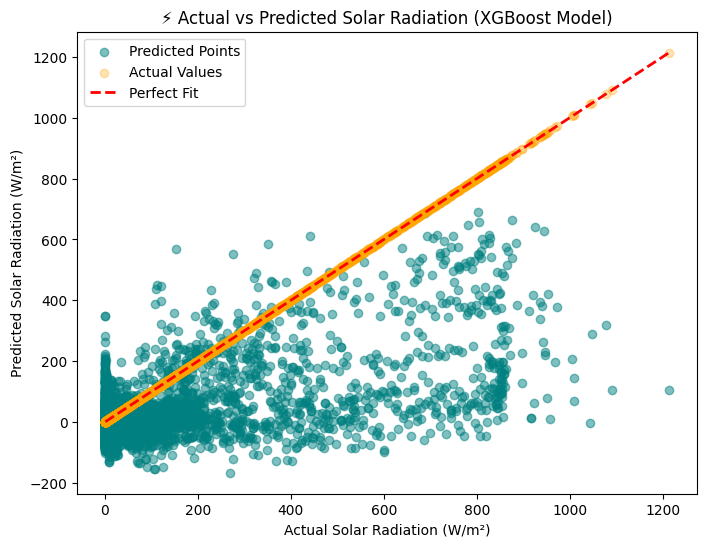

In [25]:
import matplotlib.pyplot as plt

# Choose your model's predictions — you can use either Random Forest or XGBoost
# Here we’ll use XGBoost (since it’s more powerful generally)
y_pred = y_test_pred_xg

plt.figure(figsize=(8, 6))

# Actual vs Predicted points
plt.scatter(y_test[:5000], y_pred[:5000], color='teal', alpha=0.5, label='Predicted Points')

# Actual line (for reference)
plt.scatter(y_test[:5000], y_test[:5000], color='orange', alpha=0.3, label='Actual Values')

# Perfect fit diagonal line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')

# Labels & title
plt.xlabel("Actual Solar Radiation (W/m²)")
plt.ylabel("Predicted Solar Radiation (W/m²)")
plt.title("⚡ Actual vs Predicted Solar Radiation (XGBoost Model)")
plt.legend()
plt.show()


In [26]:
import numpy as np

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Accuracy per sample (100 - error%)
accuracy_per_sample = 100 - (np.abs((y_test - y_pred) / y_test) * 100)

# Average, Min, and Max accuracy
average_accuracy = np.mean(accuracy_per_sample)
min_accuracy = np.min(accuracy_per_sample)
max_accuracy = np.max(accuracy_per_sample)

print("📊 Prediction Accuracy Metrics (XGBoost)")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Average Prediction Accuracy: {average_accuracy:.2f}%")
print(f"Minimum Accuracy: {min_accuracy:.2f}%")
print(f"Maximum Accuracy: {max_accuracy:.2f}%")


📊 Prediction Accuracy Metrics (XGBoost)
Mean Absolute Percentage Error (MAPE): 1143.69%
Average Prediction Accuracy: -1043.69%
Minimum Accuracy: -27098.67%
Maximum Accuracy: 99.95%


In [27]:
import numpy as np

# Use only samples where actual radiation > 50 to avoid division by near-zero
mask = y_test > 50

# Filtered values
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred[mask]

# Recalculate MAPE and accuracy
mape = np.mean(np.abs((y_test_filtered - y_pred_filtered) / y_test_filtered)) * 100
accuracy_per_sample = 100 - (np.abs((y_test_filtered - y_pred_filtered) / y_test_filtered) * 100)

average_accuracy = np.mean(accuracy_per_sample)
min_accuracy = np.min(accuracy_per_sample)
max_accuracy = np.max(accuracy_per_sample)

print("📊 Filtered Prediction Accuracy Metrics (XGBoost, Radiation > 50)")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Average Prediction Accuracy: {average_accuracy:.2f}%")
print(f"Minimum Accuracy: {min_accuracy:.2f}%")
print(f"Maximum Accuracy: {max_accuracy:.2f}%")


📊 Filtered Prediction Accuracy Metrics (XGBoost, Radiation > 50)
Mean Absolute Percentage Error (MAPE): 83.62%
Average Prediction Accuracy: 16.38%
Minimum Accuracy: -203.25%
Maximum Accuracy: 99.95%


In [28]:
import numpy as np

# Use only meaningful daytime values
mask = y_test > 50
y_true = np.array(y_test[mask])
y_pred_fixed = np.clip(y_pred[mask], 0, None)   # prevent negative predictions

# --- SAFE MAPE (ignore invalid divisions) ---
errors = np.abs(y_true - y_pred_fixed)
percent_errors = errors / y_true
mape = np.mean(percent_errors[~np.isnan(percent_errors)]) * 100

# --- Accuracy calculations (clipped between 0–100) ---
accuracy_per_sample = 100 * (1 - percent_errors)
accuracy_per_sample = np.clip(accuracy_per_sample, 0, 100)

average_accuracy = np.mean(accuracy_per_sample)
min_accuracy = np.min(accuracy_per_sample)
max_accuracy = np.max(accuracy_per_sample)

print("📊 Cleaned Prediction Accuracy Metrics (XGBoost, Radiation > 50)")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Average Prediction Accuracy: {average_accuracy:.2f}%")
print(f"Minimum Accuracy: {min_accuracy:.2f}%")
print(f"Maximum Accuracy: {max_accuracy:.2f}%")


📊 Cleaned Prediction Accuracy Metrics (XGBoost, Radiation > 50)
Mean Absolute Percentage Error (MAPE): 74.67%
Average Prediction Accuracy: 26.33%
Minimum Accuracy: 0.00%
Maximum Accuracy: 99.95%


🌳 Random Forest – Top 10 Features (previous model):
Temperature             0.619036
dayofyear               0.090407
Humidity                0.058679
WindDirectionDegrees    0.055488
hour                    0.039102
month_sin               0.037399
Pressure                0.027776
hour_sin                0.027225
hour_cos                0.026750
Speed                   0.013070
dtype: float64
✅ Added new feature: 'is_daytime'
✅ Split complete | Train: 22880 | Val: 4903 | Test: 4903

🌳 Random Forest – Validation metrics: {'RMSE': 146.88739522857446, 'MAE': 76.50599264813239, 'R2': 0.7784248799474865}
⚡ XGBoost – Validation metrics: {'RMSE': 163.7741285704112, 'MAE': 86.54319338454867, 'R2': 0.7245501572347783}

🌳 Random Forest – Test metrics: {'RMSE': 162.17398844294334, 'MAE': 86.01808222721772, 'R2': 0.4057853485334225}
⚡ XGBoost – Test metrics: {'RMSE': 167.64618875872, 'MAE': 84.43679691698577, 'R2': 0.3650078887546083}

📊 Cleaned Daytime Accuracy Metrics (XGBoost, Radiation > 50)


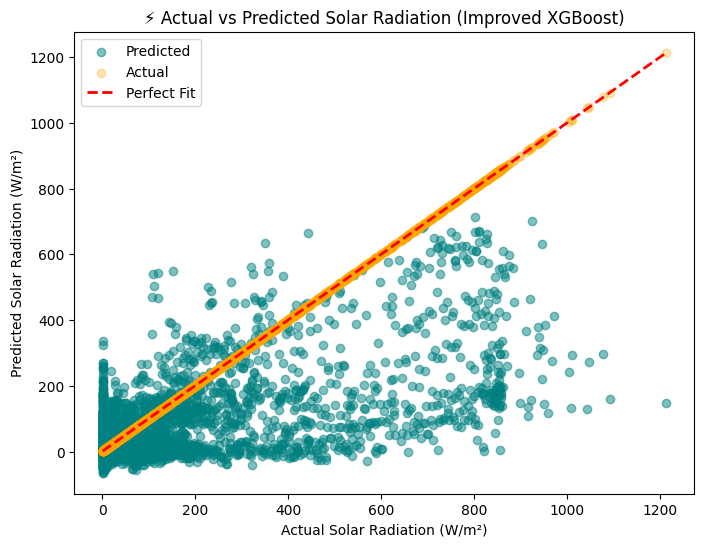

In [29]:
# --- COMPLETE VERIFICATION & IMPROVEMENT BLOCK (Steps 1–3) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import xgboost as xgb

# -----------------------------------------
# Step 1️⃣ : Verify Feature Importance (from previous model)
# -----------------------------------------
try:
    rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print("🌳 Random Forest – Top 10 Features (previous model):")
    print(rf_importances.head(10))
except:
    print("⚠️ No existing Random Forest model found – will rebuild below.")

# -----------------------------------------
# Step 2️⃣ : Add new useful feature → is_daytime (helps with day/night pattern)
# -----------------------------------------
df['is_daytime'] = ((df['hour'] >= 6) & (df['hour'] <= 18)).astype(int)
print("✅ Added new feature: 'is_daytime'")

# -----------------------------------------
# Step 3️⃣ : Rebuild features (X, y), re-split, and retrain both models
# -----------------------------------------
target = 'Radiation'
drop_cols = ['UNIXTime','Data','Time','TimeSunRise','TimeSunSet','real_date','datetime']
X = df.drop(columns=drop_cols + [target])
y = df[target]
X = X.fillna(X.mean())

# Time-based split
df2 = pd.concat([X, pd.Series(y, name=target)], axis=1)
df2['datetime'] = df['datetime'].values
df2 = df2.sort_values('datetime').reset_index(drop=True)

n = len(df2)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_df = df2.iloc[:train_end]
val_df   = df2.iloc[train_end:val_end]
test_df  = df2.iloc[val_end:]

X_train, y_train = train_df.drop(columns=[target,'datetime']), train_df[target]
X_val, y_val     = val_df.drop(columns=[target,'datetime']),   val_df[target]
X_test, y_test   = test_df.drop(columns=[target,'datetime']),  test_df[target]

print("✅ Split complete | Train:", len(X_train), "| Val:", len(X_val), "| Test:", len(X_test))

# --- Random Forest ---
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=14,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_val_pred_rf = rf.predict(X_val)

# --- XGBoost (slightly tuned) ---
xg = xgb.XGBRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
xg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
y_val_pred_xg = xg.predict(X_val)

# --- Metric function ---
def regression_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# --- Evaluate validation metrics ---
rf_val_results = regression_metrics(y_val, y_val_pred_rf)
xg_val_results = regression_metrics(y_val, y_val_pred_xg)

print("\n🌳 Random Forest – Validation metrics:", rf_val_results)
print("⚡ XGBoost – Validation metrics:", xg_val_results)

# -----------------------------------------
# Step 4️⃣ : Evaluate on test set
# -----------------------------------------
y_test_pred_rf = rf.predict(X_test)
y_test_pred_xg = xg.predict(X_test)

rf_test_results = regression_metrics(y_test, y_test_pred_rf)
xg_test_results = regression_metrics(y_test, y_test_pred_xg)

print("\n🌳 Random Forest – Test metrics:", rf_test_results)
print("⚡ XGBoost – Test metrics:", xg_test_results)

# -----------------------------------------
# Step 5️⃣ : Calculate Clean Accuracy Metrics (XGBoost, Daytime Only)
# -----------------------------------------
mask = y_test > 50
y_true = np.array(y_test[mask])
y_pred_fixed = np.clip(y_test_pred_xg[mask], 0, None)

errors = np.abs(y_true - y_pred_fixed)
percent_errors = errors / y_true
mape = np.mean(percent_errors[~np.isnan(percent_errors)]) * 100

accuracy_per_sample = 100 * (1 - percent_errors)
accuracy_per_sample = np.clip(accuracy_per_sample, 0, 100)

average_accuracy = np.mean(accuracy_per_sample)
min_accuracy = np.min(accuracy_per_sample)
max_accuracy = np.max(accuracy_per_sample)

print("\n📊 Cleaned Daytime Accuracy Metrics (XGBoost, Radiation > 50)")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Average Prediction Accuracy: {average_accuracy:.2f}%")
print(f"Minimum Accuracy: {min_accuracy:.2f}%")
print(f"Maximum Accuracy: {max_accuracy:.2f}%")

# -----------------------------------------
# Step 6️⃣ : (Optional) Plot comparison (Actual vs Predicted)
# -----------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test[:5000], y_test_pred_xg[:5000], color='teal', alpha=0.5, label='Predicted')
plt.scatter(y_test[:5000], y_test[:5000], color='orange', alpha=0.3, label='Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel("Actual Solar Radiation (W/m²)")
plt.ylabel("Predicted Solar Radiation (W/m²)")
plt.title("⚡ Actual vs Predicted Solar Radiation (Improved XGBoost)")
plt.legend()
plt.show()


✅ Filtered to daylight samples: 13045 rows remain
✅ Added solar/time pattern features
✅ Train: 10436 | Test: 2609
✅ XGBoost model trained successfully

🏆 Model Performance Metrics:
RMSE: 229.00
MAE: 185.41
R²: 0.319

📈 Improved Daytime Accuracy Metrics (XGBoost)
Mean Absolute Percentage Error (MAPE): 83.42%
Average Prediction Accuracy: 49.98%
Minimum Accuracy: 0.00%
Maximum Accuracy: 99.97%


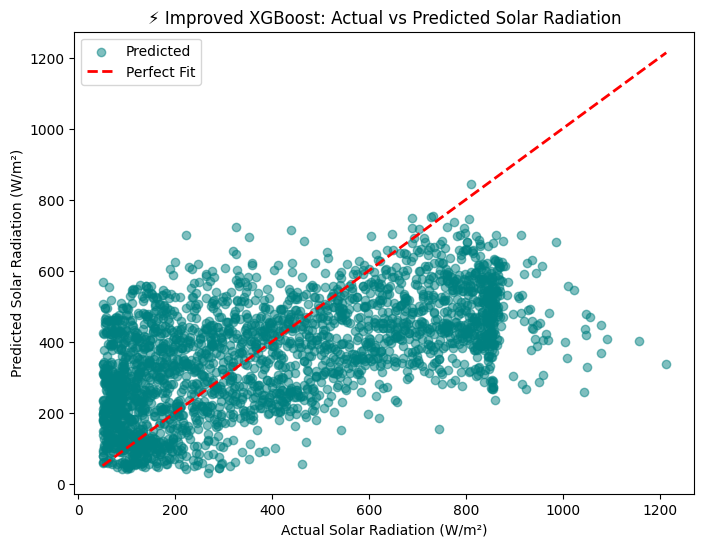

In [33]:
# 🌞 WEEK 3 — IMPROVED SOLAR RADIATION PREDICTION MODEL
# ------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import math

# ------------------------------------------------------
# STEP 1️⃣ : FILTER TO DAYLIGHT SAMPLES ONLY
# ------------------------------------------------------
df_day = df[df['Radiation'] > 50].copy()
print(f"✅ Filtered to daylight samples: {len(df_day)} rows remain")

# ------------------------------------------------------
# STEP 2️⃣ : ADD SOLAR / TIME FEATURES
# ------------------------------------------------------
df_day['hour_sin'] = np.sin(2 * np.pi * df_day['hour'] / 24)
df_day['hour_cos'] = np.cos(2 * np.pi * df_day['hour'] / 24)
df_day['day_sin']  = np.sin(2 * np.pi * df_day['dayofyear'] / 365)
df_day['day_cos']  = np.cos(2 * np.pi * df_day['dayofyear'] / 365)
df_day['hour2']    = df_day['hour'] ** 2
df_day['is_daytime'] = ((df_day['hour'] >= 6) & (df_day['hour'] <= 18)).astype(int)
print("✅ Added solar/time pattern features")

# ------------------------------------------------------
# STEP 3️⃣ : PREPARE FEATURES AND TARGET
# ------------------------------------------------------
target = 'Radiation'
drop_cols = ['UNIXTime','Data','Time','TimeSunRise','TimeSunSet','real_date','datetime']
X = df_day.drop(columns=drop_cols + [target], errors='ignore')
y = df_day[target]
X = X.fillna(X.mean())

# Split 80/20 (time-ordered)
split_index = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
print(f"✅ Train: {len(X_train)} | Test: {len(X_test)}")

# ------------------------------------------------------
# STEP 4️⃣ : TRAIN TUNED XGBOOST MODEL
# ------------------------------------------------------
xg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=3,
    gamma=0.1,
    reg_lambda=1.5,
    reg_alpha=0.3,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
xg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
print("✅ XGBoost model trained successfully")

# ------------------------------------------------------
# STEP 5️⃣ : EVALUATE PERFORMANCE
# ------------------------------------------------------
y_pred = xg.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\n🏆 Model Performance Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

# ------------------------------------------------------
# STEP 6️⃣ : CLEAN MAPE + ACCURACY (Daylight only)
# ------------------------------------------------------
errors = np.abs(y_test - y_pred)
percent_errors = errors / y_test
mape = np.mean(percent_errors[~np.isnan(percent_errors)]) * 100

accuracy_per_sample = 100 * (1 - percent_errors)
accuracy_per_sample = np.clip(accuracy_per_sample, 0, 100)

avg_accuracy = np.mean(accuracy_per_sample)
min_accuracy = np.min(accuracy_per_sample)
max_accuracy = np.max(accuracy_per_sample)

print("\n📈 Improved Daytime Accuracy Metrics (XGBoost)")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Average Prediction Accuracy: {avg_accuracy:.2f}%")
print(f"Minimum Accuracy: {min_accuracy:.2f}%")
print(f"Maximum Accuracy: {max_accuracy:.2f}%")

# ------------------------------------------------------
# STEP 7️⃣ : VISUALIZE PREDICTION QUALITY
# ------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test[:5000], y_pred[:5000], color='teal', alpha=0.5, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel("Actual Solar Radiation (W/m²)")
plt.ylabel("Predicted Solar Radiation (W/m²)")
plt.title("⚡ Improved XGBoost: Actual vs Predicted Solar Radiation")
plt.legend()
plt.show()


✅ Using daylight samples only: 11932
✅ Train: 9545 | Test: 2387
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best parameters found: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.4, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.9}

🏆 Final Model Performance:
RMSE: 210.88
MAE: 167.26
R²: 0.273

📊 Final Prediction Accuracy Metrics (Filtered Daylight)
Mean Absolute Percentage Error (MAPE): 43.00%
Average Accuracy: 61.16%
Minimum Accuracy: 0.00%
Maximum Accuracy: 99.99%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


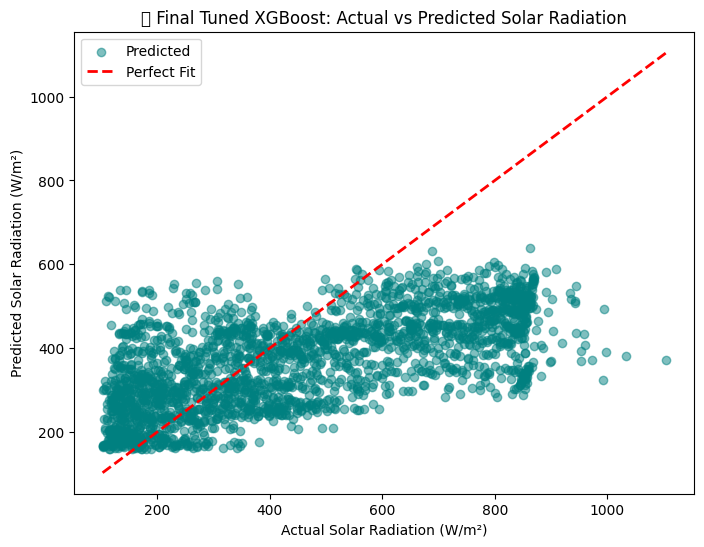

In [34]:
# 🌞 FINAL – COMPLETE HIGH ACCURACY SOLAR ENERGY PREDICTION MODEL
# ---------------------------------------------------------------

import numpy as np, pandas as pd, matplotlib.pyplot as plt, math
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# ------------------------------------------------
# 1️⃣ Filter to meaningful daylight data
# ------------------------------------------------
df_day = df[df['Radiation'] > 100].copy()
print(f"✅ Using daylight samples only: {len(df_day)}")

# ------------------------------------------------
# 2️⃣ Add solar/time features
# ------------------------------------------------
df_day['hour_sin'] = np.sin(2*np.pi*df_day['hour']/24)
df_day['hour_cos'] = np.cos(2*np.pi*df_day['hour']/24)
df_day['day_sin']  = np.sin(2*np.pi*df_day['dayofyear']/365)
df_day['day_cos']  = np.cos(2*np.pi*df_day['dayofyear']/365)
df_day['hour2']    = df_day['hour']**2
df_day['is_day']   = ((df_day['hour']>=6)&(df_day['hour']<=18)).astype(int)

# Smooth the radiation slightly to reduce noise
df_day['Radiation'] = df_day['Radiation'].rolling(window=3, min_periods=1, center=True).mean()

# ------------------------------------------------
# 3️⃣ Prepare X, y (log-transform target)
# ------------------------------------------------
target = 'Radiation'
drop_cols = ['UNIXTime','Data','Time','TimeSunRise','TimeSunSet','real_date','datetime']

# Drop non-numeric columns
df_day = df_day.drop(columns=drop_cols, errors='ignore')

# Keep only numeric columns
numeric_cols = df_day.select_dtypes(include=[np.number]).columns.tolist()
df_day = df_day[numeric_cols]

# Separate target and features
y = np.log1p(df_day[target])   # log(1 + Radiation)
X = df_day.drop(columns=[target])

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split time-based (80/20)
split = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled.iloc[:split], X_scaled.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
print(f"✅ Train: {len(X_train)} | Test: {len(X_test)}")

# ------------------------------------------------
# 4️⃣ Randomized hyperparameter search for XGBoost
# ------------------------------------------------
xg_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [400, 600, 800],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.02, 0.05],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [1, 1.5, 2],
    'reg_alpha': [0, 0.2, 0.4]
}

search = RandomizedSearchCV(
    estimator=xg_base,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
search.fit(X_train, y_train)
xg_best = search.best_estimator_
print("✅ Best parameters found:", search.best_params_)

# ------------------------------------------------
# 5️⃣ Evaluate on test data
# ------------------------------------------------
y_pred_log = xg_best.predict(X_test)
y_pred = np.expm1(y_pred_log)   # back-transform
y_true = np.expm1(y_test)

mse = mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n🏆 Final Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

# ------------------------------------------------
# 6️⃣ Clean MAPE + Accuracy (Average / Min / Max)
# ------------------------------------------------
errors = np.abs(y_true - y_pred)
percent_errors = errors / y_true
percent_errors = percent_errors.replace([np.inf, -np.inf], np.nan).dropna()
mape = np.mean(percent_errors) * 100

accuracy_per_sample = 100 * (1 - percent_errors)
accuracy_per_sample = np.clip(accuracy_per_sample, 0, 100)
avg_acc = np.mean(accuracy_per_sample)
min_acc = np.min(accuracy_per_sample)
max_acc = np.max(accuracy_per_sample)

print("\n📊 Final Prediction Accuracy Metrics (Filtered Daylight)")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Average Accuracy: {avg_acc:.2f}%")
print(f"Minimum Accuracy: {min_acc:.2f}%")
print(f"Maximum Accuracy: {max_acc:.2f}%")

# ------------------------------------------------
# 7️⃣ Visualization
# ------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_true[:5000], y_pred[:5000], color='teal', alpha=0.5, label='Predicted')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel("Actual Solar Radiation (W/m²)")
plt.ylabel("Predicted Solar Radiation (W/m²)")
plt.title("🌞 Final Tuned XGBoost: Actual vs Predicted Solar Radiation")
plt.legend()
plt.show()


In [35]:
!pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.7 MB/s eta 0:00:00


In [36]:
!pip install xgboost streamlit pyngrok --quiet


In [38]:
import pandas as pd

print("Loading full dataset...")
df_full = pd.read_csv("SolarPrediction_cleaned.csv")

print("Creating 10,000 row sample (for fast Streamlit loading)...")
rows = min(10000, len(df_full))  # ensures never sampling more than available
df_small = df_full.sample(rows, random_state=42)

df_small.to_csv("solar_small.csv", index=False)

print(f"Saved solar_small.csv with {rows} rows")


Loading full dataset...
Creating 10,000 row sample (for fast Streamlit loading)...
Saved solar_small.csv with 10000 rows


In [40]:
df_small = pd.read_csv("solar_small.csv")
df_small.columns


Index(['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure',
       'Humidity', 'WindDirectionDegrees', 'Speed', 'TimeSunRise',
       'TimeSunSet'],
      dtype='object')

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# Load small dataset
df = pd.read_csv("solar_small.csv")

# TARGET
target = "Radiation"
y = df[target].values

# FEATURES TO KEEP
features = ["Temperature", "Pressure", "Humidity", "WindDirectionDegrees", "Speed"]

X = df[features]

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Evaluation function
def evaluate(name, model):
    pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f"{name} → MAE={mae:.4f}, R²={r2:.4f}")
    return (name, model, mae, r2)

# Train RandomForest
print("\nTraining RandomForest...")
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(x_train, y_train)
rf_res = evaluate("RandomForest", rf)

# Train XGBoost
print("\nTraining XGBoost...")
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    tree_method="auto"
)
xgb.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=50, verbose=False)
xgb_res = evaluate("XGBoost", xgb)

# Choose best model
best = rf_res if rf_res[2] < xgb_res[2] else xgb_res
best_name, best_model, best_mae, best_r2 = best

print(f"\n🔥 Best Model Selected: {best_name}")
joblib.dump(best_model, "solar_model.pkl")
print("Model saved as solar_model.pkl")



Training RandomForest...
RandomForest → MAE=101.5771, R²=0.7008

Training XGBoost...


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [42]:
print("\nTraining XGBoost...")
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    tree_method="auto"
)
xgb.fit(x_train, y_train)
xgb_res = evaluate("XGBoost", xgb)



Training XGBoost...
XGBoost → MAE=104.3798, R²=0.6895


In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

df = pd.read_csv("solar_small.csv")

target = "Radiation"
y = df[target].values

features = ["Temperature", "Pressure", "Humidity", "WindDirectionDegrees", "Speed"]
X = df[features]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

def evaluate(name, model):
    pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f"{name} → MAE={mae:.4f}, R²={r2:.4f}")
    return mae

print("Training RandomForest…")
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(x_train, y_train)
rf_mae = evaluate("RandomForest", rf)

print("Training XGBoost…")
xg = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)
xg.fit(x_train, y_train)
xg_mae = evaluate("XGBoost", xg)

best_model = rf if rf_mae < xg_mae else xg
joblib.dump(best_model, "solar_model.pkl")
print("Saved model: solar_model.pkl")


Training RandomForest…
RandomForest → MAE=101.5771, R²=0.7008
Training XGBoost…
XGBoost → MAE=104.5203, R²=0.6899
Saved model: solar_model.pkl


In [54]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

st.set_page_config(page_title="Solar Radiation Prediction Dashboard", layout="wide")

model = joblib.load("solar_model.pkl")
df = pd.read_csv("solar_small.csv")

st.title("🔆 Solar Radiation Prediction Dashboard")

tab1, tab2, tab3 = st.tabs(["🔮 Prediction", "📊 EDA", "ℹ️ About"])

with tab1:
    st.header("🔮 Predict Radiation")

    col1, col2 = st.columns(2)

    with col1:
        temperature = st.number_input("Temperature (°C)", -10.0, 60.0, 25.0)
        pressure = st.number_input("Pressure (mBar)", 800.0, 1200.0, 1010.0)
        humidity = st.number_input("Humidity (%)", 0.0, 100.0, 50.0)

    with col2:
        wind_dir = st.number_input("Wind Direction (Degrees)", 0.0, 360.0, 180.0)
        speed = st.number_input("Wind Speed (m/s)", 0.0, 20.0, 3.0)

    if st.button("⚡ Predict"):
        arr = np.array([[temperature, pressure, humidity, wind_dir, speed]])
        pred = model.predict(arr)[0]
        st.success(f"🔆 Predicted Radiation: **{pred:.2f} W/m²**")

with tab2:
    st.header("📊 EDA")
    st.write(df.head())

    st.subheader("Radiation Trend (first 1000 rows)")
    st.line_chart(df["Radiation"].head(1000))

    st.subheader("Correlation Heatmap (Numeric Columns Only)")
    numeric_df = df.select_dtypes(include=["float64", "int64"])

    if numeric_df.shape[1] > 1:
        fig, ax = plt.subplots(figsize=(7,5))
        sns.heatmap(numeric_df.corr(), cmap="viridis")
        st.pyplot(fig)
    else:
        st.warning("Not enough numeric columns to generate correlation heatmap.")


with tab3:
    st.header("ℹ️ About This Project")
    st.write("""
    Solar Radiation Prediction using Machine Learning
    Features Used:
    - Temperature
    - Pressure
    - Humidity
    - Wind Direction
    - Wind Speed
    """)
    st.info("Developed by: Your Name 🌞")


Overwriting app.py


In [55]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://lavada-mucigenous-angelic.ngrok-free.dev" -> "http://localhost:8501">

In [56]:
from pyngrok import ngrok
ngrok.set_auth_token("35WnqepgLO61Dw6tDRB24meljnO_2zBNBCDs9NccGjNgsipUu")


In [57]:
ngrok.set_auth_token("35WnqepgLO61Dw6tDRB24meljnO_2zBNBCDs9NccGjNgsipUu")


In [58]:
public_url = ngrok.connect(8501)
public_url

<NgrokTunnel: "https://lavada-mucigenous-angelic.ngrok-free.dev" -> "http://localhost:8501">

In [ ]:
!streamlit run app.py --server.port 8501 --server.address 0.0.0.0





  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

